Apparent Competition

In [2]:
push!(LOAD_PATH, pwd()) # put current directory on path
using Revise
using UnPack
#include("ModelHelperFuns.jl")  # load the file
#using .ModelHelperFuns         # bring the module into scope
using CooperativeHuntingPkg
using Plots
default(
    guidefontsize=17,   # controls xlabel, ylabel, title font size
    tickfontsize=12,    # controls axis number labels
    legendfontsize=14,  # controls legend font
    linewidth=4,        # controls default line thickness
    grid = false,        # turns off grid in background
    fontfamily="Computer Modern" # font family that matches latex
)
using BifurcationKit, DifferentialEquations
# pgfplotsx()  # Set PGFPlotsX as the backend # this seems to not work on my computer, or on vscode.
using Measures # helps for adjusting location of axis labels
using LinearAlgebra
using ForwardDiff #this should be able to numerically find a jacobian
using LaTeXStrings

# saving with bif diagrams
bif_fig_path = "/Users/taliaborofsky/Documents/CH_GroupFormation/CH_manuscript/FIgures/BifurcationDiagrams/"

"/Users/taliaborofsky/Documents/CH_GroupFormation/CH_manuscript/FIgures/BifurcationDiagrams/"

# Functions and label dictionaries

In [3]:
# these were supposed to load with my package but i guess it didn't work
ylabel_dic = Dict(
    :N1 => L"N_1"*", Scaled Big Prey\nDensity",
    :N2 => L"N_2"*", Scaled Small Prey\nDensity",
    :mean_x => "Mean Experienced\nGroup Size, "*L"\bar{x}",
    :p => L"Predator density, $p$",
    :Nsum => "Sum of Prey Densities,\n"*L"N_1 + N_2",
    :g1 => L"g(1)",
    :g2 => L"g(2)",
    :g3 => L"g(3)"
)

param_label_dic = Dict(
    :α1_of_1 => L"\alpha_1(1)",
    :α2_of_1 => L"\alpha_2(1)",
    :s1 => L"s_1",
    :s2 => L"s_2",
    :H1a => L"H_{1a}",
    :H2a => L"H_{2a}",
    :H2b => L"H_{2b}",
    :A1 => L"Relative Attack Rate of Big Prey, $A_1$",
    :A2 => L"A_2",
    :η2 => L"Growth of Small Prey, $\eta_2$",
    :β2 => L"\beta_2",
    :x_max => L"x_{max}",
    :Tg => "Relative Group Dynamics \nTimescale, "*L"T_g",
    :d => L"d",
    :scale => L"Scale, $\beta_1/\beta_2$"
)
params_base = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2.0,
    :s2 => 2.0,
    :H1a => 0.0,
    :H2a => 0.0,
    :H2b => 0.0,
    :A1 => 0.6,
    :A2 => 0.5,
    :η2 => 0.6,
    :β2 => 1.0,
    :α2_fun_type => "constant",
    :x_max => 5,
    :Tg => .01,
    :d => 100.0,
    :scale => 5.0
)
function get_apparent_comp_bothways(stable_coexist, gmat, params)
    num = length(stable_coexist[:N1])
    ∂N2_∂N1 = zeros(num)
    ∂N1_∂N2 = zeros(num)
    for i in 1:num
        # set up inputs
        N1 = stable_coexist[:N1][i]
        N2 = stable_coexist[:N2][i]
        g = gmat[i,:]
        params_use = deepcopy(params)
        params_use[:scale] = stable_coexist[:param][i]
        params_use = scale_parameters(params_use)
        @unpack scale, β1, β2, η1, η2, A1, A2, H1b, H2b = params_use
        # get jacobian
        #J= ForwardDiff.jacobian(u->fullsystem_scaled(u,params_use), [N1,N2,g...])
        J = Jacobian(N1,N2,g,params_use)
        ∂N2_∂N1[i] = get_∂N2_∂N1(J)
        ∂N1_∂N2[i] = get_∂N1_∂N2(J)
    end
    return ∂N2_∂N1, ∂N1_∂N2
end

function get_stable_equilibria(params)
    @unpack x_max = params
    u0 = fill(0.1, x_max+2)
    p_nt = NamedTuple(scale_parameters(params))
    br_list = do_base_continuations(p_nt, x_max);

    br_coexist = br_list[:coexist]
    filtered_coexist = extract_branch_matrix(br_coexist, params[:x_max])
    indices = findall(xvec -> xvec==1.0, filtered_coexist.stable)

    stable_coexist = Dict()
    for (key, value) in pairs(filtered_coexist)
        stable_coexist[key] = value[indices]
    end

    # store g's in a matrix
    gmat = fill(1.0, (length(stable_coexist[:N1]), params[:x_max]))
    for i in 1:5
        gmat[:,i] = stable_coexist[Symbol("g$i")]
    end
    return stable_coexist, gmat
end
function plot_distribution_heatmap(gmat, stable_coexist, x_max)
    # prob_x_mat: matrix (rows = param values, cols = x values)
    prob_x_mat = get_prob_in_x(gmat, stable_coexist[:P], x_max);
    # stable_coexist[:param]: vector for x-axis
    # xvec: vector for y-axis (e.g., 1:x_max)
    xvec = 1:x_max
    plt_heat = heatmap(
        stable_coexist[:param], 
        xvec, 
        prob_x_mat', 
        color = :coolwarm,         # black (1) to white (0)
        clim = (0, maximum(prob_x_mat) + .01),          # scale from 0 (white) to 1 (black)
        xlabel = param_label_dic[:scale], 
        ylabel = L"Group size, $x$",
        right_margin = 15mm,
        #colorbar_titlefontrotation = 180,
        yflip = false            # optional: flip y-axis if you want black at the top
    )
    plot!(
        stable_coexist[:param],
        stable_coexist[:mean_x],
        label = L"\bar{x}",
        color = :black,
        linewidth=4
    )
    annotate!(
        (1.2, 0.5),
        text(L"\textrm{Prob.\ in\ group\ size}\ x", 16, :center, rotation = -90),
        
    )
    return plt_heat
end

function find_mangel_clark(N1, N2, params)
    # Mangel and Clark predicted that groups should grow until W(x^*) = W(1)
    # Simplest way: iterate and stop when W(x) < W(1), then return x - 1
    @unpack x_max = params
    W_of_1 = fun_W(1, N1, N2, params)
    for x in 2:x_max
        W_of_x = fun_W(x, N1, N2, params)
        if W_of_x < W_of_1
            return x - 1
        end
    end
    return x_max  # If reach x_max
end

function plot_mc_line(plt, stable_coexist, params_base)
    x_list_mangel_clark = []
    params = deepcopy(params_base)
    for (i,param) in enumerate(stable_coexist[:param])
        # get parameter value and prey values
        N1 = stable_coexist[:N1][i]
        N2 = stable_coexist[:N2][i]
        params[:scale] = param

        # update parameters dictionary using scaling laws
        params = scale_parameters(params)

        # get mangel and clark prediction
        x_mc = find_mangel_clark(N1, N2, params)
        push!(x_list_mangel_clark, x_mc)
    end
    # plot
    plot!(stable_coexist[:param], x_list_mangel_clark, color = :yellow,
    label=L"Clark & Mangel $x^*$")
end

plot_mc_line (generic function with 1 method)

# Type I, varying scale

## Get stable equilibria

In [4]:
params_t1 = deepcopy(params_base)
stable_coexist_t1, gmat_t1 = get_stable_equilibria(params_t1)

(Dict{Any, Any}(:g5 => [0.03392820574686391, 0.028288696037644515, 0.02355007021224764, 0.019584314146202597, 0.016275915963177276, 0.013522746119552712, 0.011235916228311922, 0.009339008303360534, 0.007766960942532003, 0.006464808879673198  …  2.366673623875367e-7, 2.3620694570195696e-7, 2.3574777756104716e-7, 2.352898510056571e-7, 2.3483315915771422e-7, 2.3437769521895795e-7, 2.339234524695954e-7, 2.334704242669979e-7, 2.3301860404454342e-7, 2.329464742671941e-7], :g3 => [0.27764183789772195, 0.2805909843082791, 0.28288756340123017, 0.28458186244642175, 0.2857260111752158, 0.2863719706376636, 0.28657014616641047, 0.2863684852869588, 0.2858119370265138, 0.2849421723700782  …  0.04278537832359036, 0.04268292474482203, 0.04258081296108009, 0.0424790413250481, 0.042377608200564174, 0.04227651196252432, 0.04217575099677618, 0.04207532370001999, 0.04197522847971404, 0.04195925498154295], :g2 => [0.2711190360719066, 0.27264951527645703, 0.27389798651407593, 0.27488602818945035, 0.2756350287

In [5]:
∂N2_∂N1_t1, ∂N1_∂N2_t1 = get_apparent_comp_bothways(
    stable_coexist_t1, gmat_t1, params_t1
    )

([-1.4933542303047227, -1.447278303527548, -1.4123497767372617, -1.3862664699963512, -1.3672585045486363, -1.353950461076658, -1.3452634398375558, -1.3403441305566801, -1.3385125915694285, -1.339223256348794  …  -3.9493581719662605, -3.9511974768167577, -3.95302449892425, -3.9548392851782364, -3.956641882308858, -3.9584323369322147, -3.9602106955226675, -3.961977004423512, -3.9637313098528115, -3.9640106950716527], [-0.7980810764594256, -0.8151096200313639, -0.8287891673245492, -0.8395039338529845, -0.8476336209883077, -0.8535368686531916, -0.8575416522331828, -0.8599408717311964, -0.8609915297353824, -0.8609161916598269  …  -0.32891313219032914, -0.328694915447734, -0.3284778058415263, -0.32826179698730296, -0.328046882547154, -0.3278330562295909, -0.3276203117893485, -0.32740864302812644, -0.32719804379182515, -0.3271644699297518])

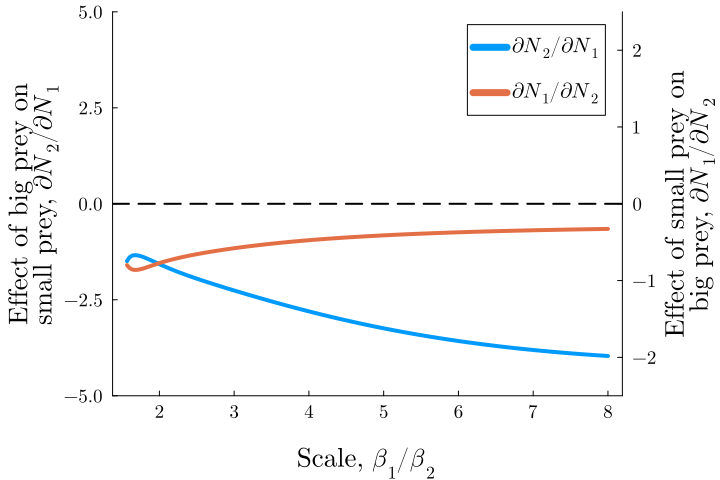

In [60]:
plt = plot(
    stable_coexist_t1[:param], # i looked at the values and 207 is about where there's a change
    ∂N2_∂N1_t1, 
    label = L"\partial N_2/\partial N_1", 
    color = 1, 
    ylabel = "Effect of big prey on\n"*L"small prey, $\partial N_2/\partial N_1$",
    xlab = "\n"*param_label_dic[:scale],
    ylims = [-5,5]
    )
annotate!((5.0,10,"Facilitatation"))
annotate!((5.0,-10,"Competition"))
plot!([],[], color = :white, label = " ")
plot!([],[], color = 2,label = L"\partial N_1/\partial N_2") # need this in order to show both labels
plot!(
    twinx(), stable_coexist_t1[:param], ∂N1_∂N2_t1, 
    label = nothing,#[L"N_2 \to N_1"], 
    ylabel = "Effect of small prey on\n"*L"big prey, $\partial N_1/\partial N_2$",
    color = 2,
    ylims = [-2.5,2.5])
hline!([0], color = :black, linestyle = :dash, linewidth = 2, label = nothing)
plot!(
    legend = :topright,
    bottommargin = 3mm, # prevents xlab from being cutoff
    right_margin=4mm,
    left_margin=4mm,
    size = (720,480)
)

savefig(plt, bif_fig_path*"apparent_comp_t1_scale.pdf")
plt


## Plot Distribution

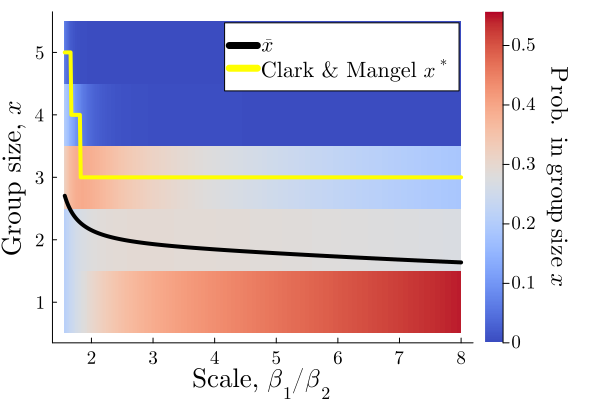

In [7]:
x_max = 5
plt = plot_distribution_heatmap(gmat_t1, stable_coexist_t1, x_max)
plot_mc_line(plt, stable_coexist_t1, params_t1)
savefig(plt, bif_fig_path*"distribution_t1_scale.pdf")
plt


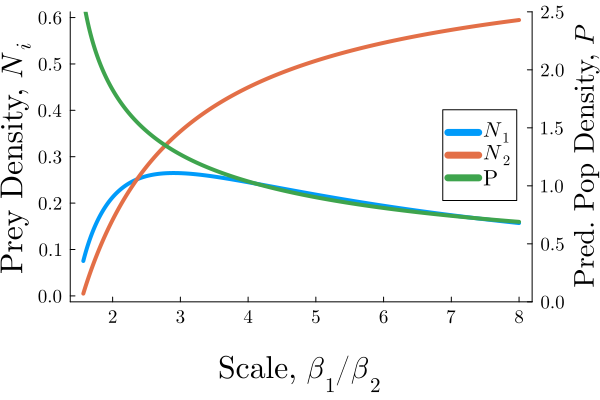

In [45]:
#size_explanatory_plots = (600, 133)
plt_N = plot(
    stable_coexist[:param], 
    stable_coexist[:N1], 
    label = L"N_1",
    linewidth=4
    )
plot!(
    stable_coexist[:param], 
    stable_coexist[:N2], 
    label = L"N_2",
    linewidth=4
    )
plot!([],[],color=3, linewidth=4, label = "P")
plot!(ylab = L"Prey Density, $N_i$",
    xlab = "\n"*param_label_dic[:scale],
    bottommargin = 5mm,
    guidefontsize=20,
    legend = :right
    )#ylab = "Scaled Prey Density\nat Equilibrium"
plot!(
    twinx(), stable_coexist[:param], stable_coexist[:P], 
    label = nothing,#[L"N_2 \to N_1"], 
    ylabel = L"Pred. Pop Density, $P$",
    color = 3,
    linewidth=4,
    ylims = [0,2.5])
savefig(plt_N, bif_fig_path*"stable_N_t1_scale.pdf")
plt_N


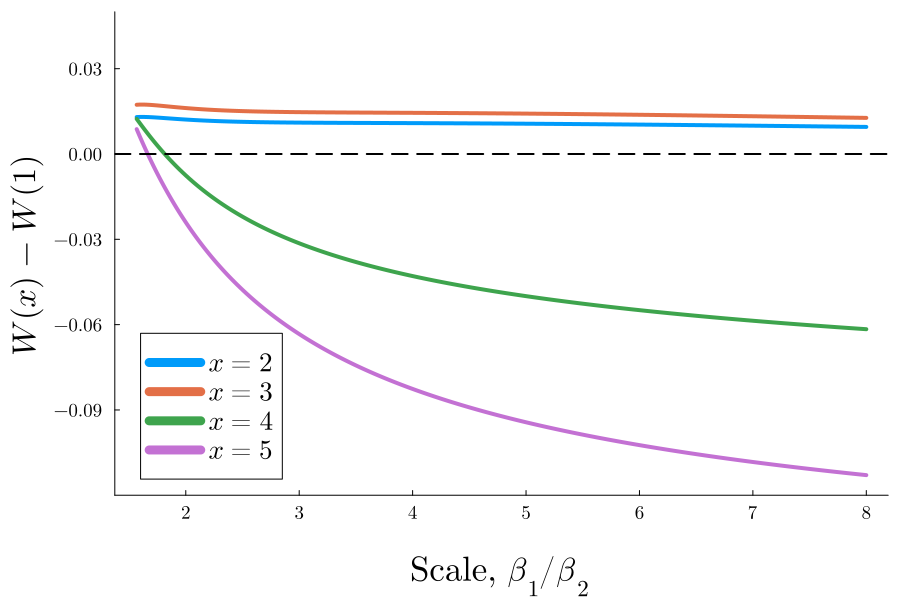

In [60]:
# explanatory figures
# get W mat
num = length(stable_coexist[:N1])
xvec = 1:x_max
Wmat = zeros(num,x_max)
for i in 1:num
    # set up inputs
    N1 = stable_coexist[:N1][i]
    N2 = stable_coexist[:N2][i]
    params_use = deepcopy(params)
    params_use[:scale] = stable_coexist[:param][i]
    params_use = scale_parameters(params_use)
    
    Wmat[i,:] = fun_W(xvec,N1,N2,params_use)
end
# plot heatmap of W
# stable_coexist[:param]: vector for x-axis
# xvec: vector for y-axis (e.g., 1:x_max)
xvec = 1:x_max
plt = plot(
    xlab = "\n"*param_label_dic[:scale],
    ylab = L"W(x) - W(1)",
    bottommargin=5mm)
for x in xvec[2:end]
    plot!(stable_coexist[:param], Wmat[:,x] .- Wmat[:,1], label = L"x=%$x",
    guidefontsize=22, left_margin = 5mm, legendfontsize=18,
    linewidth=4,
    )
end
plot!(ylim = [-0.12,0.05])
hline!([0],linestyle=:dash, color = :black, label = nothing,size=(600,400).*1.5)
savefig(plt, bif_fig_path*"W_t1_scale.pdf")
plt



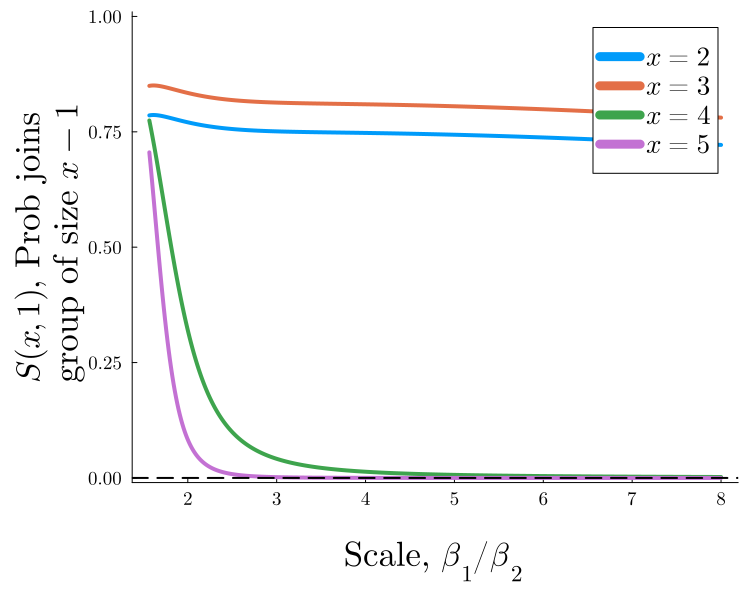

In [87]:
# explanatory figures
# get W mat
num = length(stable_coexist_t1[:N1])
xvec = 1:x_max
Wmat = zeros(num,x_max)
for i in 1:num
    # set up inputs
    N1 = stable_coexist_t1[:N1][i]
    N2 = stable_coexist_t1[:N2][i]
    params_use = deepcopy(params)
    params_use[:scale] = stable_coexist_t1[:param][i]
    params_use = scale_parameters(params_use)
    
    Wmat[i,:] = fun_W(xvec,N1,N2,params_use)
end
# plot heatmap of W
# stable_coexist[:param]: vector for x-axis
# xvec: vector for y-axis (e.g., 1:x_max)
xvec = 1:x_max
plt = plot(
    xlab = "\n"*param_label_dic[:scale],
    ylab = L"$S(x,1)$, Prob joins"*"\n group of"* L" size $x-1$",
    bottommargin=5mm)
for x in xvec[2:end]
    plot!(
        stable_coexist_t1[:param], 
        1 ./(1 .+ exp.(-params[:d] .* (Wmat[:,x] .- Wmat[:,1]))), 
        label = L"x=%$x",
    guidefontsize=22, left_margin = 5mm, legendfontsize=18,
    linewidth=4,
    )
end
plot!(ylim = [-0.01,1.01])
hline!([0],linestyle=:dash, color = :black, label = nothing,size=(500,400).*1.5)
#savefig(plt, bif_fig_path*"W_t1_scale.pdf")
plt



## Scale vs eta2

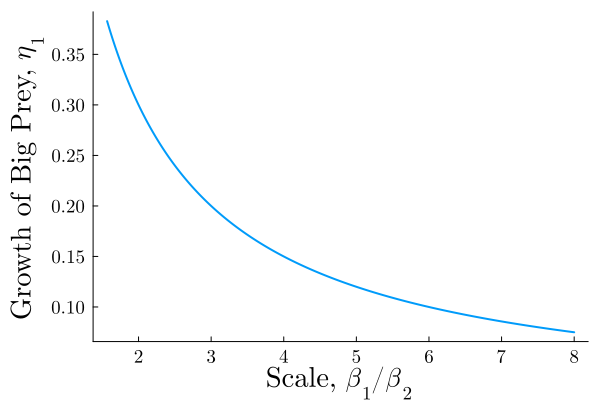

In [96]:
scale = stable_coexist_t1[:param]
η2 = params_t1[:η2]
η1 = η2 ./ scale

plot(
    scale, η1, label = nothing,
    ylab = L"Growth of Big Prey, $\eta_1$",
    xlab = param_label_dic[:scale],
    left_margin = 5mm)

- compare this to group size without population dynamics
    to isolate the population dynamics is reducing group sizes
- need to S(x,1) curves
- even though most predators are singletons, there aren't many predators, which reduces the rate of group formation from predators running into each other

# Type II, varying scale

## Get Stable Equilibria

In [8]:
params_base = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2.0,
    :s2 => 2.0,
    :H1a => 0.0,
    :H2a => 0.0,
    :H2b => 0.0,
    :A1 => 0.6,
    :A2 => 0.5,
    :η2 => 0.6,
    :β2 => 1.0,
    :α2_fun_type => "constant",
    :x_max => 5,
    :Tg => .01,
    :d => 100.0,
    :scale => 5.0
)
# type II, vary scale
params_t2 = deepcopy(params_base)
params_t2[:H1a] = params_t2[:H2a] = 0.0
params_t2[:H2b] = 1.0
stable_coexist_t2, gmat_t2 = get_stable_equilibria(params_t2)
∂N2_∂N1_t2, ∂N1_∂N2_t2 = get_apparent_comp_bothways(stable_coexist_t2, gmat_t2, params_t2)

([-1.4874267111503334, -1.4352759412568739, -1.394442657187368, -1.3624655819761577, -1.3374843691812612, -1.3180735712290361, -1.3031284013885305, -1.291784275392107, -1.2833589836282588, -1.2773103898821048  …  -3.209818207429739, -3.1864787458100796, -3.1636287166327643, -3.141255890957885, -3.119348397349305, -3.0978947085546245, -3.0768836287813706, -3.0563042815545005, -3.036146098145554, -3.032628709177939], [-0.8041850905087835, -0.8240102924349358, -0.8406404905117464, -0.8544532632171837, -0.8658123340881794, -0.8750555356362191, -0.8824883371426981, -0.8883814091634642, -0.8929709076132911, -0.8964604406735941  …  -0.3714092278067307, -0.372349739490139, -0.373275791870347, -0.3741873550341632, -0.37508440560769296, -0.37596692671107257, -0.3768349079060405, -0.3776883451397213, -0.37852724068035687, -0.37867389737470275])

## Plot Apparent Competition

In [43]:
400*1.2

480.0

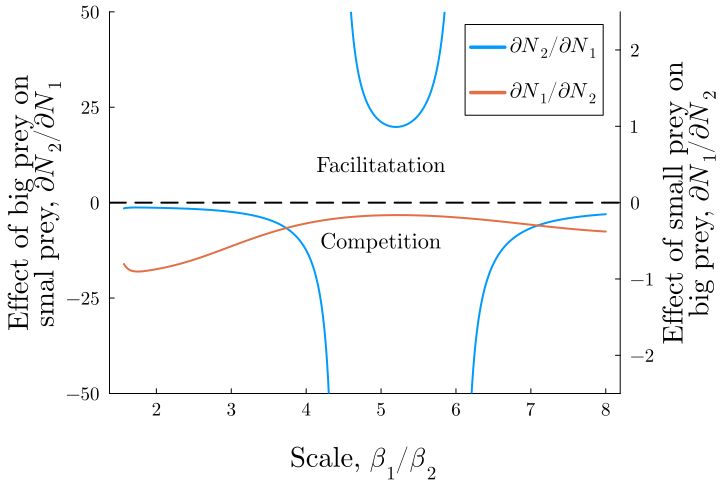

In [ ]:

plt = plot(
    stable_coexist_t2[:param][1:206], # i looked at the values and 207 is about where there's a change
    ∂N2_∂N1_t2[1:206], 
    label = L"\partial N_2/\partial N_1", 
    color = 1, 
    ylabel = "Effect of big prey on\n"*"smal prey, "*L"\partial N_2/\partial N_1",
    xlab = "\n"*param_label_dic[:scale],
    ylims = [-50,50]
    )
annotate!((5.0,10,"Facilitatation"))
annotate!((5.0,-10,"Competition"))
plot!(stable_coexist_t2[:param][207:321], ∂N2_∂N1_t2[207:321], 
    label = nothing, color = 1)
plot!(stable_coexist_t2[:param][322:end], ∂N2_∂N1_t2[322:end], 
    label = nothing, color = 1)
plot!([], [], color = :white, label = " ")
plot!([],[], color = 2,label = L"\partial N_1/\partial N_2")
plot!(
    twinx(), stable_coexist_t2[:param], ∂N1_∂N2_t2, 
    label = nothing,#[L"N_2 \to N_1"], 
    ylabel = "Effect of small prey on\n"*L"big prey, $\partial N_1/\partial N_2$",
    color = 2,
    ylims = [-2.5,2.5])
hline!([0], color = :black, linestyle = :dash, linewidth = 2, label = nothing)
plot!(
    legend = :topright,
    rightmargin=4mm,
    leftmargin=4mm,
    bottommargin = 3mm, # prevents xlab from being cutoff
    size=(720,480)
)

savefig(plt, bif_fig_path*"apparent_comp_t2_scale.pdf")
plt


## Explanatory figures: distribution, p, N1, N2, W

plot_distribution_heatmap (generic function with 1 method)

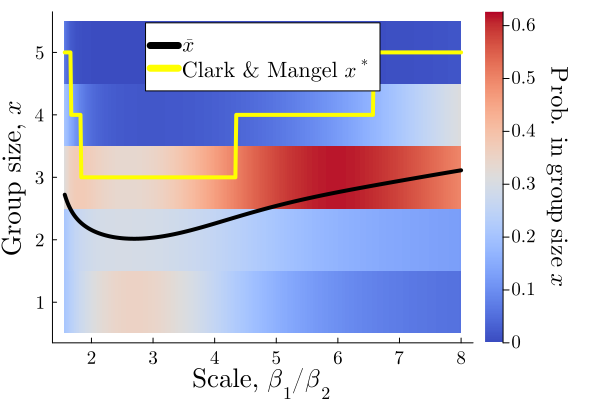

In [9]:
plt_heat = plot_distribution_heatmap(gmat_t2, stable_coexist_t2, 5)
plot_mc_line(plt, stable_coexist_t2, params_t2)
plot!(legend=:top)
savefig(plt_heat, bif_fig_path*"distribution_t2_scale.pdf")
plt_heat


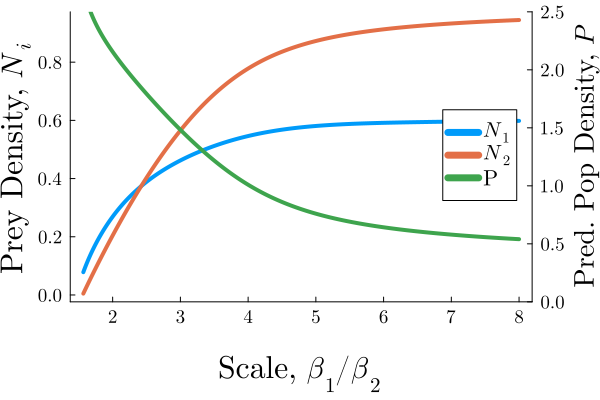

In [113]:
#size_explanatory_plots = (600, 133)
plt_N = plot(
    stable_coexist_t2[:param], 
    stable_coexist_t2[:N1], 
    label = L"N_1",
    linewidth=4
    )
plot!(
    stable_coexist_t2[:param], 
    stable_coexist_t2[:N2], 
    label = L"N_2",
    linewidth=4
    )
plot!([],[],color=3, linewidth=4, label = "P")
plot!(ylab = L"Prey Density, $N_i$",
    xlab = "\n"*param_label_dic[:scale],
    bottommargin = 5mm,
    guidefontsize=20,
    legend = :right
    )#ylab = "Scaled Prey Density\nat Equilibrium"
plot!(
    twinx(), stable_coexist_t2[:param], stable_coexist_t2[:P], 
    label = nothing,#[L"N_2 \to N_1"], 
    ylabel = L"Pred. Pop Density, $P$",
    color = 3,
    linewidth=4,
    ylims = [0,2.5])
savefig(plt_N, bif_fig_path*"stable_N_t2_scale.pdf")
plt_N


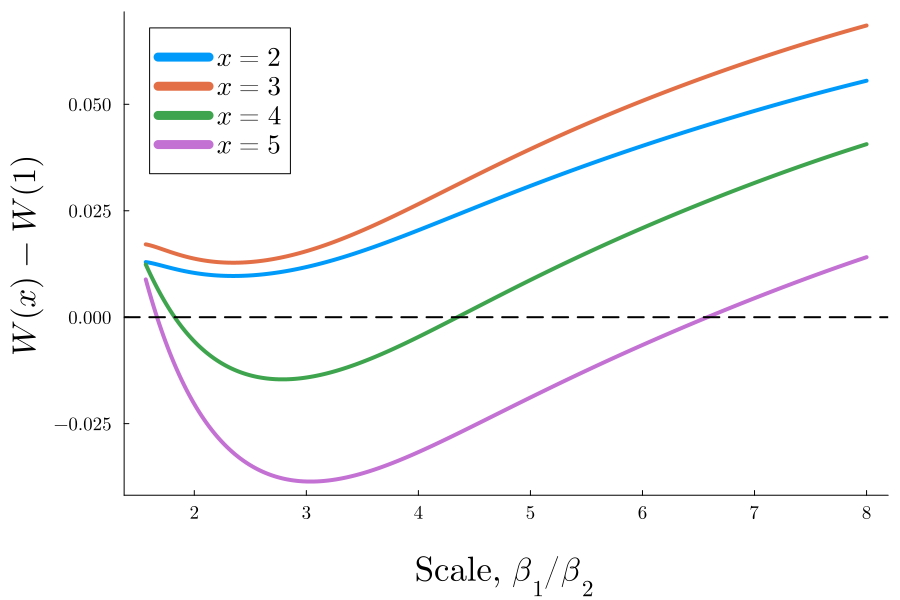

In [114]:
# explanatory figures
# get W mat
num = length(stable_coexist_t2[:N1])
xvec = 1:x_max
Wmat = zeros(num,x_max)
for i in 1:num
    # set up inputs
    N1 = stable_coexist_t2[:N1][i]
    N2 = stable_coexist_t2[:N2][i]
    params_use = deepcopy(params_t2)
    params_use[:scale] = stable_coexist_t2[:param][i]
    params_use = scale_parameters(params_use)
    
    Wmat[i,:] = fun_W(xvec,N1,N2,params_use)
end
# plot heatmap of W
# stable_coexist_t2[:param]: vector for x-axis
# xvec: vector for y-axis (e.g., 1:x_max)
xvec = 1:x_max
plt = plot(
    xlab = "\n"*param_label_dic[:scale],
    ylab = L"W(x) - W(1)",
    bottommargin=5mm)
for x in xvec[2:end]
    plot!(stable_coexist_t2[:param], Wmat[:,x] .- Wmat[:,1], label = L"x=%$x",
    guidefontsize=22, left_margin = 5mm, legendfontsize=18,
    linewidth=4,
    )
end
hline!([0],linestyle=:dash, color = :black, label = nothing,size=(600,400).*1.5)
savefig(plt, bif_fig_path*"W_t2_scale.pdf")
plt



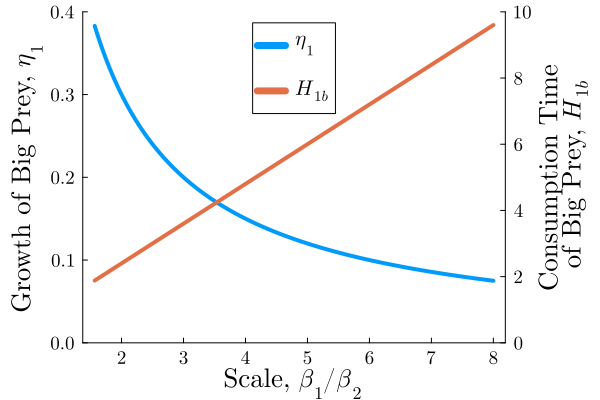

In [83]:
scale = stable_coexist_t2[:param]
@unpack η2, H2b, A1, A2 = params_t2
H1b = scale .* A1 * H2b / A2
η1 = η2 ./ scale

plt = plot(
    scale, η1, label = L"~\eta_1", 
    linewidth=4,
    ylab = L"Growth of Big Prey, $\eta_1$",
    xlab = param_label_dic[:scale],
    left_margin = 5mm,
    legend=:top,
    ylim = (0,0.4),
)
plot!([],[],color=:white, label = " ")
plot!([],[],linewidth=4,color=2,label=L"~H_{1b}")

plot!(twinx(),
    scale, H1b, label = nothing, linewidth=4,color=2,
    ylabel = "Consumption Time\n of Big Prey, "*L"H_{1b}",
    ylim = (0,10),
    right_margin=5mm
    )
savefig(plt, bif_fig_path*"params_t2_scale.pdf")
plt


In [63]:
(600,400).*1.25

(750.0, 500.0)

In [46]:
(gmat[1,:] .* x)./stable_coexist[:p][1] .== prob_in_x[1,:]

5-element BitVector:
 1
 1
 1
 1
 1

In [35]:
stable_coexist[:p]

461-element Vector{Float64}:
 2.702351873546111
 2.671831359368061
 2.643171522183158
 2.616205051181343
 2.590771825094445
 2.5667221814079446
 2.543918573912431
 2.522236108750257
 2.50156234786936
 2.481796667815313
 ⋮
 0.5432681365079433
 0.542803536770169
 0.5423417326938926
 0.5418827092209918
 0.5414264514341859
 0.5409729445512819
 0.5405221739195358
 0.5400741250102394
 0.5399952715738388

In [ ]:
# get prob_x
# this is xg(x)/p

In [ ]:


# get system state for first entry
xvec = 1:x_max
N1 = stable_coexist[:N1][1]; N2 = stable_coexist[:N2][1]; g = gmat[1,:]
params_use = deepcopy(params)
params_use[:scale] = stable_coexist[:param][1]
params_use = scale_parameters(params_use)

Dict{Symbol, Any} with 19 entries:
  :A1          => 0.6
  :α1_of_1     => 0.05
  :β2          => 1.0
  :H2b         => 1.0
  :Tg          => 0.01
  :d           => 100.0
  :β1          => 1.56684
  :η1          => 0.382935
  :H1b         => 1.88021
  :A2          => 0.5
  :s1          => 2.0
  :H1a         => 0.0
  :H2a         => 0.0
  :scale       => 1.56684
  :x_max       => 5
  :α2_of_1     => 0.95
  :η2          => 0.6
  :α2_fun_type => "constant"
  :s2          => 2.0

In [23]:
u0 = [N1, N2, g...]
println(u0)
p_nt = NamedTuple(params_use)
tspan = (0.0, 500)
prob = ODEProblem(fullsystem_scaled!, u0, tspan, p_nt)
sol = solve(prob)  
sol.u[end]
#prob = simulate_and_plot(u0, p_nt; tf = 500)

[0.07830622136115241, 0.004706460090317248, 0.5541382555739873, 0.27988066949519674, 0.28590000893207, 0.13664892549173563, 0.03683131004371562]


7-element Vector{Float64}:
 0.07830622136116624
 0.004706460090343335
 0.5541382555741592
 0.2798806694952587
 0.28590000893207207
 0.13664892549168525
 0.03683131004368425

In [8]:
J = Jacobian(N1, N2, g, params_use)


7×7 Matrix{Float64}:
   -0.0166884       0.00950067  …    -0.0451463     -0.0455937
    0.000894702    -0.0894525        -0.00215409    -0.00216975
 -990.794        1643.15             50.691        145.893
  -88.7484        126.247             0.0            0.0
   84.4729         14.67             90.0123         0.0
  140.673        -233.542       …  -129.338        145.904
   70.5427       -200.981            39.3259      -145.904

In [11]:
get_∂N1_∂N2(J)

1.4312819304741862

In [1]:
J = zeros(5,5)

5×5 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [ ]:
J[1:end .!=2, 1:end .!= 2]

4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

In [ ]:
params = deepcopy(params_base)
params[:H1a] = params[:H2a] = 0.0
params[:H2b] = 1.0
params[:scale] = 6.0
params[:A1]=0.6
params[:Tg] = 0.01
p_nt = NamedTuple(scale_parameters(params))

(A1 = 0.6, α1_of_1 = 0.05, β2 = 1.0, H2b = 1.0, Tg = 0.01, d = 100.0, β1 = 6.0, η1 = 0.09999999999999999, H1b = 7.199999999999999, A2 = 0.5, s1 = 2.0, H1a = 0.0, H2a = 0.0, scale = 6.0, x_max = 5, α2_of_1 = 0.95, η2 = 0.6, α2_fun_type = "constant", s2 = 2.0)

In [194]:
N1 = .89
N2 = .6
g = [.01, .1, 1, 0.05, 0.01]
J_analytical = Jacobian(N1,N2,g, params)


7×7 Matrix{Float64}:
 -0.153927    0.0181131    -0.014124  …  -0.157586   -0.194347  -0.222894
  0.0732664  -0.285533     -0.150762     -0.0885313  -0.104012  -0.118977
 -0.233977    0.397011   -117.489        -0.994285   -0.886588   3.34265
 -0.0410665   0.0370312    -8.76442       0.905441    0.0        0.0
 -0.315765   -0.036774    -89.9728       -2.93921     1.30964    0.0
  0.203386    0.19614      94.9915    …   2.03377    -3.57596    3.38632
  0.166431   -0.217692      4.98114       0.0         2.26632   -3.38632

In [195]:
u0 = [N1,N2,g...]
println(p_nt)
J_fd = ForwardDiff.jacobian(u->fullsystem_scaled(u,params), u0)


(A1 = 0.6, α1_of_1 = 0.05, β2 = 1.0, H2b = 1.0, Tg = 0.01, d = 100.0, β1 = 6.0, η1 = 0.09999999999999999, H1b = 7.199999999999999, A2 = 0.5, s1 = 2.0, H1a = 0.0, H2a = 0.0, scale = 6.0, x_max = 5, α2_of_1 = 0.95, η2 = 0.6, α2_fun_type = "constant", s2 = 2.0)


7×7 Matrix{Float64}:
 -0.153927    0.0181131    -0.014124  …  -0.157586   -0.194347  -0.222894
  0.0732664  -0.285533     -0.150762     -0.0885313  -0.104012  -0.118977
 -0.233977    0.397011   -117.489        -0.994285   -0.886588   3.34265
 -0.0410665   0.0370312    -8.76442       0.905441    0.0        0.0
 -0.315765   -0.036774    -89.9728       -2.93921     1.30964    0.0
  0.203386    0.19614      94.9915    …   2.03377    -3.57596    3.38632
  0.166431   -0.217692      4.98114       0.0         2.26632   -3.38632

In [196]:
abs.(J_analytical - J_fd).>1e-4

7×7 BitMatrix:
 0  0  0  0  0  0  0
 0  0  0  0  0  0  0
 0  0  0  0  0  0  0
 0  0  0  0  0  0  0
 0  0  0  0  0  0  0
 0  0  0  0  0  0  0
 0  0  0  0  0  0  0

In [102]:
u0 = [1.0,1.0,zeros(5)]
J= ForwardDiff.jacobian(u->fullsystem_scaled(u,p_nt), u0)

MethodError: MethodError: no method matching one(::Type{Any})
This error has been manually thrown, explicitly, so the method may exist but be intentionally marked as unimplemented.

Closest candidates are:
  one(::Type{Union{Missing, T}}) where T
   @ Base missing.jl:105
  one(!Matched::Type{Union{}}, Any...)
   @ Base number.jl:349
  one(!Matched::Type{Missing})
   @ Base missing.jl:104
  ...


In [100]:
br_list.predator_extinct.eig

562-element Vector{@NamedTuple{eigenvals::Vector{ComplexF64}, eigenvecs::Matrix{ComplexF64}, converged::Bool, step::Int64}}:
 (eigenvals = [5.844183830302029 + 0.0im, -0.6 + 0.0im, -5.999999999999999 + 0.0im, -188.52460403429774 + 0.0im, -283.02440982157395 + 0.0im, -377.5014312483289 + 0.0im, -474.0901756749782 + 0.0im], eigenvecs = [0.0013151854095906988 + 0.0im 0.0 + 0.0im … -2.4610029881369944e-5 + 0.0im 5.7747140770067574e-5 + 0.0im; 0.03771866152238308 + 0.0im 1.0 + 0.0im … -3.3623601594221094e-5 + 0.0im 1.060030264142711e-5 + 0.0im; … ; -1.4923179999629364e-9 + 0.0im 0.0 + 0.0im … 0.11889309364072866 + 0.0im -0.318783543867282 + 0.0im; -1.3178767323088398e-12 + 0.0im 0.0 + 0.0im … 0.0005309228491354155 + 0.0im 0.06435698929642886 + 0.0im], converged = 1, step = 0)
 (eigenvals = [5.461107819112868 + 0.0im, -0.6 + 0.0im, -5.616869185735882 + 0.0im, -189.28538344129424 + 0.0im, -284.1699184370509 + 0.0im, -379.03238608836364 + 0.0im, -476.01834203695506 + 0.0im], eigenvecs = [0.001

# Note that you can use ForwardDiff to numerically find the Jacobian!

I used this to check my jacobian

In [ ]:
br_coexist = br_list[:coexist]
filtered_coexist = extract_branch_matrix(br_coexist, params[:x_max])
indices = findall(xvec -> xvec==1.0, filtered_coexist.stable)

stable_coexist = Dict()
for (key, value) in pairs(filtered_coexist)
    stable_coexist[key] = value[indices]
end

# store g's in a matrix
gmat = fill(1.0, (length(stable_coexist[:N1]), params[:x_max]))
for i in 1:5
    gmat[:,i] = stable_coexist[Symbol("g$i")]
end

# get system state for first entry
xvec = 1:x_max
N1 = stable_coexist[:N1][1]; N2 = stable_coexist[:N2][1]; g = gmat[1,:]
params_use = deepcopy(params)
params_use[:scale] = stable_coexist[:param][1]
params_use = scale_parameters(params_use)

u0 = [N1,N2,g...]

J = ForwardDiff.jacobian(u->fullsystem_scaled(u,params_use), u0)

7×7 Matrix{Float64}:
   -0.0166884       0.00950067  …    -0.0451463     -0.0455937
    0.000894702    -0.00113274       -0.00215409    -0.00216975
 -990.794        1643.15             50.691        145.893
  -88.7484        126.247             0.0            0.0
   84.4729         14.67             90.0123         0.0
  140.673        -233.542       …  -129.338        145.904
   70.5427       -200.981            39.3259      -145.904